## 데이터 불러오기

In [1]:
# Google Drive를 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 필요한 라이브러리 설치
!pip install pycaret
!pip install catboost
!pip install mlxtend

# 데이터 처리 및 모델링을 위한 라이브러리
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 모델링 관련 라이브러리
import xgboost as xgb
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

# 데이터 불균형 처리를 위한 라이브러리
from imblearn.over_sampling import SMOTE

# 성능 평가 지표
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

# 하이퍼파라미터 튜닝을 위한 라이브러리
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

train = '/content/drive/MyDrive/김동영/LG aimers/LG aimers 해커톤/원본/train.csv'
try:
    df_train = pd.read_csv(train, encoding='ISO-8859-1')
except UnicodeDecodeError:
    df_train = pd.read_csv(train, encoding='cp1252')

sub = '/content/drive/MyDrive/김동영/LG aimers/LG aimers 해커톤/원본/submission.csv'
try:
    df_test = pd.read_csv(sub, encoding='ISO-8859-1')
except UnicodeDecodeError:
    df_test = pd.read_csv(sub, encoding='cp1252')

sub1 = '/content/drive/MyDrive/김동영/LG aimers/LG aimers 해커톤/원본/submission.csv'
try:
    df_sub = pd.read_csv(sub1, encoding='ISO-8859-1')
except UnicodeDecodeError:
    df_sub = pd.read_csv(sub1, encoding='cp1252')


## 전처리

In [5]:
# 훈련 및 테스트 데이터를 결합하여 동일한 데이터 전처리 적용
combined_data = pd.concat([df_train, df_test.drop(columns=['id'])], ignore_index=True)

In [6]:
combined_data.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


In [7]:
combined_data.describe()

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,lead_desc_length,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner
count,64570.000000,16356.000000,64570.000000,15031.000000,4037.0,1174.0,5211.0,64570.000000,64570.000000,64570.000000,20790.000000,17210.000000,64570.000000
mean,0.632236,0.092849,26914.552315,20.027610,1.0,1.0,1.0,79.479309,0.050194,0.053306,0.001114,0.050296,265.983862
std,0.293474,0.151108,14666.049872,48.039031,0.0,0.0,0.0,132.758693,0.218346,0.224646,0.001114,0.029054,232.710329
min,0.000000,0.003788,1.000000,0.000000,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.000002,0.011583,0.000000
25%,0.500000,0.024432,14614.250000,1.000000,1.0,1.0,1.0,7.000000,0.000000,0.000000,0.000298,0.026846,97.000000
50%,0.500000,0.049180,26527.000000,4.000000,1.0,1.0,1.0,29.000000,0.000000,0.000000,0.000572,0.049840,175.000000
75%,1.000000,0.074949,40177.250000,19.000000,1.0,1.0,1.0,93.000000,0.000000,0.000000,0.001183,0.064566,375.000000
max,1.000000,1.000000,47466.000000,2219.000000,1.0,1.0,1.0,1264.000000,1.000000,1.000000,0.003079,0.285714,1114.000000


In [8]:
# 결측치 값 확인하기
combined_data.isnull().sum()

bant_submit                    0
customer_country             982
business_unit                  0
com_reg_ver_win_rate       48214
customer_idx                   0
customer_type              45418
enterprise                     0
historical_existing_cnt    49539
id_strategic_ver           60533
it_strategic_ver           63396
idit_strategic_ver         59359
customer_job               20172
lead_desc_length               0
inquiry_type                2233
product_category           21232
product_subcategory        54542
product_modelname          54779
customer_country.1           982
customer_position              0
response_corporate             0
expected_timeline          33271
ver_cus                        0
ver_pro                        0
ver_win_rate_x             43780
ver_win_ratio_per_bu       47360
business_area              43780
business_subarea           57228
lead_owner                     0
is_converted                5271
dtype: int64

결측치를 확인해 본 결과 결측치가 있는 컬럼이 없는 컬럼보다 더 많은 것을 확인할 수 있었다.

결측치가 있는 컬럼: customer_country, com_reg_ver_win_rate, customer_type, historical_existing_cnt, id_strategic_ver,it_strategic_ver, idit_strategic_ver, customer_job, inquiry_type,product_category,product_subcategory ,product_modelname,customer_country.1, ver_win_rate_x,ver_win_ratio_per_bu,business_area, business_subarea

결측치가 없는 컬럼: bant_submit, business_unit, customer_idx, enterprise, lead_desc_length, customer_position, response_corporate, ver_cus, ver_pro, lead_owner

In [9]:
# value_counts로 각 컬럼의 고유값 확인하기
for col in combined_data.columns:
    print(f"{col}: {combined_data[col].value_counts()}")

bant_submit: bant_submit
1.00    19131
0.50    17859
0.25    14374
0.75    12226
0.00      980
Name: count, dtype: int64
customer_country: customer_country
//India                          3055
/SÃ£o Paulo/Brazil               1344
//United States                  1122
//United Kingdom                  807
//Saudi Arabia                    719
                                 ... 
/Chichester/United Kingdom          1
/Newport/United Kingdom             1
/Moray/United Kingdom               1
/Herefordshire/United Kingdom       1
/ Ongole  / India                   1
Name: count, Length: 17521, dtype: int64
business_unit: business_unit
ID          27905
AS          27184
IT           9183
Solution      296
CM              2
Name: count, dtype: int64
com_reg_ver_win_rate: com_reg_ver_win_rate
0.074949    1130
0.003937     803
0.642857     802
0.073248     791
0.003788     713
            ... 
0.017241       3
0.010989       3
0.086957       2
0.018182       2
0.055556       2
Name: coun

In [10]:
combined_data.describe()

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,lead_desc_length,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner
count,64570.000000,16356.000000,64570.000000,15031.000000,4037.0,1174.0,5211.0,64570.000000,64570.000000,64570.000000,20790.000000,17210.000000,64570.000000
mean,0.632236,0.092849,26914.552315,20.027610,1.0,1.0,1.0,79.479309,0.050194,0.053306,0.001114,0.050296,265.983862
std,0.293474,0.151108,14666.049872,48.039031,0.0,0.0,0.0,132.758693,0.218346,0.224646,0.001114,0.029054,232.710329
min,0.000000,0.003788,1.000000,0.000000,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.000002,0.011583,0.000000
25%,0.500000,0.024432,14614.250000,1.000000,1.0,1.0,1.0,7.000000,0.000000,0.000000,0.000298,0.026846,97.000000
50%,0.500000,0.049180,26527.000000,4.000000,1.0,1.0,1.0,29.000000,0.000000,0.000000,0.000572,0.049840,175.000000
75%,1.000000,0.074949,40177.250000,19.000000,1.0,1.0,1.0,93.000000,0.000000,0.000000,0.001183,0.064566,375.000000
max,1.000000,1.000000,47466.000000,2219.000000,1.0,1.0,1.0,1264.000000,1.000000,1.000000,0.003079,0.285714,1114.000000


id_strategic_ver, it_strategic_ver, idit_strategic_ver 결측치는 0으로 채웠다.

In [11]:
# Filling missing values with 0 for specific columns
columns_to_fill = ['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver']
combined_data[columns_to_fill] = combined_data[columns_to_fill].fillna(0)

# Checking missing values again to confirm the changes
combined_data[columns_to_fill].isnull().sum()

id_strategic_ver      0
it_strategic_ver      0
idit_strategic_ver    0
dtype: int64

# 결측치가 없는 컬럼 EDA

In [12]:
# business_unit 별 True 비율
conversion_rates = df_train.groupby('business_unit')['is_converted'].mean()

business_area_conversion_rates_sorted_desc = conversion_rates.sort_values(ascending=False)
print(business_area_conversion_rates_sorted_desc)

business_unit
ID          0.102492
IT          0.097415
AS          0.055825
Solution    0.010135
CM          0.000000
Name: is_converted, dtype: float64


###각 business_unit과 business_area 별 True 비율을 확인해본 결과 고유값마다 비율이 다달랐다.



### 시도해볼 만한 것: business_area가 hospital&health care 이면서 business_unit이 ID, IT인 경우를 구분해줄 변수를 만들어 준다.

In [16]:
# 'business_area'가 'hospital & health care'이고 'business_unit'이 'ID' 또는 'IT'인 행 추출
filtered_df = df_train[(df_train['business_area'] == 'hospital & health care')& (df_train['business_unit'].isin(['ID', 'IT']))]

print(filtered_df)


# is_converted가 True인 행의 개수 추출
converted_count = filtered_df[filtered_df['is_converted']].shape[0]

# 결과 출력
print("Converted count:", converted_count)

       bant_submit                                   customer_country  \
21121         0.25                                         /U.p/India   
23771         1.00                                            //India   
23772         0.25                                                NaN   
23773         1.00                                     /LUCKNOW/India   
23774         1.00                                      /MUMBAI/India   
...            ...                                                ...   
54948         0.50        41 Jones Road  Medical/Revere/United States   
54949         0.50    290 Motor Pkwy  Medical/Hauppauge/United States   
54950         0.50  620 Hungerford Drive Suite 29 Medical/Rockvill...   
54951         0.50  32652 County Road 152  Medical/Park Rapids/Uni...   
54952         0.50        264 Boston Rd  Medical/Sutton/United States   

      business_unit  com_reg_ver_win_rate  customer_idx customer_type  \
21121            IT                   NaN         

###response_corporate 마다 is_converted 전환율이 상이했다.

###시도해볼 만한 것: is_converted 전환율을 기준으로 response_corporate를 범주화해준다.

In [21]:
# Calculating the conversion rate (True values) for each response_corporate
# 오름차순으로 정렬
response_corporate_conversion_rates = df_train.groupby('response_corporate')['is_converted'].mean()

response_corporate_conversion_rates_sorted_desc = response_corporate_conversion_rates.sort_values(ascending=False)
print(response_corporate_conversion_rates_sorted_desc)

response_corporate
LGETT    0.553191
LGELA    0.500000
LGEAF    0.454861
LGECZ    0.428571
LGEHK    0.415144
LGERO    0.310345
LGEMC    0.300000
LGEPT    0.189189
LGETH    0.178378
LGEAR    0.173116
LGEUS    0.161041
LGEHS    0.156863
LGEIN    0.138790
LGEAP    0.128415
LGEGF    0.124709
LGESA    0.100746
LGESW    0.096774
LGEPH    0.089400
LGESL    0.089080
LGESJ    0.078965
LGEEB    0.076923
LGECI    0.076046
LGEPS    0.073482
LGESP    0.072065
LGECL    0.071695
LGEIL    0.071327
LGEBN    0.070707
LGEPL    0.070588
LGEMK    0.069486
LGEFS    0.056291
LGEMS    0.055997
LGEML    0.054545
LGEDG    0.049477
LGELF    0.040146
LGEPR    0.038904
LGEYK    0.038462
LGECB    0.035594
LGEEF    0.031447
LGECH    0.030769
LGEAS    0.030303
LGEES    0.025338
LGEEG    0.022727
LGETK    0.022181
LGEVH    0.021173
LGEUK    0.015142
LGEIS    0.007853
LGEKR    0.004619
LGEBT    0.000000
LGEJP    0.000000
LGEUR    0.000000
LGEIR    0.000000
LGERA    0.000000
LGEAG    0.000000
Name: is_converted, dtype: 

In [28]:
# response_corporate별로 is_converted가 True인 개수를 추출하고 오름차순으로 정렬
converted_counts_sorted_asc = df_train[df_train['is_converted'] == True].groupby('response_corporate').size().sort_values(ascending=True)

print(converted_counts_sorted_asc)

response_corporate
LGELA       1
LGEAS       1
LGEEB       1
LGEKR       2
LGECH       2
LGESW       3
LGECZ       3
LGEYK       3
LGEEF       5
LGEML       6
LGEBN       7
LGEHS       8
LGERO       9
LGEMC       9
LGEIS       9
LGELF      11
LGETK      12
LGEVH      13
LGEES      15
LGEEG      16
LGEFS      17
LGECI      20
LGEPT      21
LGEMK      23
LGEUK      25
LGETT      26
LGESA      27
LGESL      31
LGETH      33
LGEIN      39
LGEPR      44
LGEAP      47
LGEDG      52
LGEPL      60
LGECB      74
LGEAR      85
LGEPS      92
LGECL      96
LGESJ     116
LGEAF     131
LGEMS     155
LGEHK     159
LGEPH     237
LGEGF     268
LGESP     671
LGEUS     959
LGEIL    1206
dtype: int64


response_rate에서 True값이 가장 많은 순으로 묶어서 파생변수를 만들어 줄 수 있다.

In [29]:
# 'response_rate' 컬럼에서 일부 행만 필터링
allowed_units = ['LGEIL','LGEUS','LGESP','LGEGF','LGEPH','LGEHK','LGEMS','LGEAF','LGESJ']
filtered_nan = df_train[df_train['response_corporate'].isin(allowed_units)]

# 결과 출력
print(filtered_nan)

filtered_nan['is_converted'].mean() # is_converted True 비율

# is_converted가 True인 행의 개수 추출
converted_count = filtered_nan[filtered_nan['is_converted']].shape[0]

# 결과 출력
print("Converted count:", converted_count)

       bant_submit           customer_country business_unit  \
0             1.00   /Quezon City/Philippines            AS   
1             1.00         /PH-00/Philippines            AS   
2             1.00            /Kolkata /India            AS   
3             1.00         /Bhubaneswar/India            AS   
4             1.00           /Hyderabad/India            AS   
...            ...                        ...           ...   
59285         0.50       /Minas Gerais/Brazil            AS   
59286         0.50       /Minas Gerais/Brazil            AS   
59287         0.50                 /TO/Brazil            AS   
59288         0.50                 /TO/Brazil            AS   
59291         0.75  /Estado de Mexico /Mexico            AS   

       com_reg_ver_win_rate  customer_idx          customer_type  enterprise  \
0                  0.066667         32160           End-Customer  Enterprise   
1                  0.066667         23122           End-Customer  Enterprise   
2  

### customer position

In [ ]:
# Calculating the conversion rate (True values) for each customer_position
# 오름차순으로 정렬
customer_position_conversion_rates = df_train.groupby('customer_position')['is_converted'].mean()

customer_position_conversion_rates_sorted_desc = customer_position_conversion_rates.sort_values(ascending=False)
print(customer_position_conversion_rates_sorted_desc)

customer_position
architecture/consult      1.0
no influence              1.0
guest faculty             1.0
physics faculty           1.0
president                 1.0
                         ... 
educator                  0.0
education professional    0.0
education                 0.0
distributor               0.0
fÅorvos                  0.0
Name: is_converted, Length: 117, dtype: float64


In [ ]:
# is_converted 비율이 1인 고유값 필터링
filtered_rates = customer_position_conversion_rates_sorted_desc[customer_position_conversion_rates_sorted_desc != 0]

# 출력
print(filtered_rates)

customer_position
architecture/consult     1.000000
no influence             1.000000
guest faculty            1.000000
physics faculty          1.000000
president                1.000000
commercial consultant    1.000000
co-founder               1.000000
career coach             1.000000
decision-maker           0.666667
customer                 0.600000
architect/consultant     0.500000
decision maker           0.444444
not applicable           0.428571
physics teacher          0.333333
decision influencer      0.333333
decision-influencer      0.285714
unpaid                   0.235294
associate/analyst        0.125144
engineering              0.111111
manager                  0.100523
partner                  0.091483
director                 0.089407
c-level executive        0.086957
vice president           0.086444
none                     0.083791
ceo/founder              0.082415
employee                 0.071429
other                    0.063548
homeowner                0.047

###vercus가 1인 lead는 business_area가 corporate/office, education, hotel&accomodation, retail이면서 customer_type이 end-user인 경우이다.

In [ ]:
# ver_cus 별 True 비율
conversion_rates = df_train.groupby('ver_cus')['is_converted'].mean()

conversion_rates

ver_cus
0    0.078160
1    0.165383
Name: is_converted, dtype: float64

###ver_pro가 1인 lead는 business_area가 corporate/office, hotel&accomodation, retail이면서 product_category가 signage인 경우이다.
###signage 모델은 LG의 디스플레이 장치이다.

In [ ]:
# ver_pro 별 True 비율
conversion_rates = df_train.groupby('ver_pro')['is_converted'].mean()

conversion_rates

ver_pro
0    0.081228
1    0.092267
Name: is_converted, dtype: float64

### 시도해 볼 만한 것

###1. customer_type이 end-user를 구분해주는 파생 변수를 만들어준다.

###2. product_category가 디스플레이가전(signage, monitor, one quick)이면서 business_unit이 ID인 경우를 구분해주는 파생변수를 만들어준다.

###3. product_category가 vrf인 경우를 구분해주는 파생변수를 만들어준다.

In [ ]:
# product category가 'signage'인 경우만 따로 추출
signage_rows = df_train.dropna(subset=['product_category'])
signage_rows = signage_rows[signage_rows['product_category'].str.contains('signage', case=False)]

print(signage_rows)

signage_rows['is_converted'].mean() # 사이니지 모델의 is_converted True 비율

# is_converted가 True인 행의 개수 추출
converted_count = signage_rows[signage_rows['is_converted']].shape[0]

# 결과 출력
print("Converted count:", converted_count)

       bant_submit                  customer_country business_unit  \
388           1.00                           //India            ID   
389           1.00            /Bengaluru Urban/India            ID   
390           1.00                           //India            ID   
391           1.00                     /NAGPUR/India            ID   
392           1.00                           //India            ID   
...            ...                               ...           ...   
59153         1.00  /Villa Maria - Cordoba/Argentina            ID   
59154         1.00  /Villa Maria - Cordoba/Argentina            ID   
59159         0.25                         //Germany            ID   
59160         0.25                         //Germany            ID   
59161         1.00                   /CABA/Argentina            ID   

       com_reg_ver_win_rate  customer_idx customer_type  enterprise  \
388                0.057534         20487  End-Customer  Enterprise   
389              

In [ ]:
# Reset index of signage_rows
signage_rows.reset_index(drop=True, inplace=True)

# product category가 'signage'인 경우만 따로 추출
vrf_rows = df_train.dropna(subset=['product_category'])
vrf_rows = vrf_rows[vrf_rows['product_category'].str.contains('vrf', case=False)]

# Print or use the vrf_rows DataFrame
print(vrf_rows)

vrf_rows['is_converted'].mean() #  vrf제품의 is_converted True 비율

# is_converted가 True인 행의 개수 추출
converted_count = vrf_rows[vrf_rows['is_converted']].shape[0]

# 결과 출력
print("Converted count:", converted_count)

       bant_submit           customer_country business_unit  \
3             1.00         /Bhubaneswar/India            AS   
7             1.00            /Guwahati/India            AS   
9             0.75     /hauz khas,delhi/India            AS   
10            0.75               /hosur/India            AS   
12            0.75            /Kolkata /India            AS   
...            ...                        ...           ...   
59285         0.50       /Minas Gerais/Brazil            AS   
59286         0.50       /Minas Gerais/Brazil            AS   
59291         0.75  /Estado de Mexico /Mexico            AS   
59293         1.00           /SlÄskie/Poland            AS   
59294         1.00           /SlÄskie/Poland            AS   

       com_reg_ver_win_rate  customer_idx          customer_type  enterprise  \
3                  0.088889          4919           End-Customer  Enterprise   
7                  0.088889         17983           End-Customer         SMB   
9  

In [ ]:
# NaN 값을 제거한 후 필터링을 수행합니다.
filtered_rows = df_train.dropna(subset=['product_category'])

# product_category 컬럼에서 signage, monitor, one quick을 포함하는 행 필터링
filtered_rows = filtered_rows[
    filtered_rows['product_category'].str.contains('signage|monitor|one quick|one:quick', case=False, na=False)
]

# business_unit이 ID인 행만 필터링
filtered_rows = filtered_rows[filtered_rows['business_unit'] == 'ID']

# 결과 출력
print(filtered_rows)

filtered_rows['is_converted'].mean() # is_converted True 비율

# is_converted가 True인 행의 개수 추출
converted_count = filtered_rows[filtered_rows['is_converted']].shape[0]

# 결과 출력
print("Converted count:", converted_count)

       bant_submit                  customer_country business_unit  \
388           1.00                           //India            ID   
389           1.00            /Bengaluru Urban/India            ID   
390           1.00                           //India            ID   
391           1.00                     /NAGPUR/India            ID   
392           1.00                           //India            ID   
...            ...                               ...           ...   
59153         1.00  /Villa Maria - Cordoba/Argentina            ID   
59154         1.00  /Villa Maria - Cordoba/Argentina            ID   
59159         0.25                         //Germany            ID   
59160         0.25                         //Germany            ID   
59161         1.00                   /CABA/Argentina            ID   

       com_reg_ver_win_rate  customer_idx customer_type  enterprise  \
388                0.057534         20487  End-Customer  Enterprise   
389              

# 결측치 있는 컬럼 EDA

###파생변수 고려해볼 만한 것: inquiry type이 구매와 관련된 고유값인 경우와 business_unit이 ID,IT,AS인 경우를 구분해줄 수 있는 변수를 생성

In [44]:
# # NaN 값을 제거한 후 필터링을 수행합니다.
filtered_nan = df_train.dropna(subset=['inquiry_type'])

# inquity_type 컬럼에서 구매관련된 요청 행 필터링
filtered_nan = filtered_nan[
    filtered_nan['inquiry_type'].str.contains('Quotation or purchase consultation|Customer Suggestions|sales|Sales Inquiry|quotation_or_purchase_consultation|Purchase or Quotation|Product Information', case=False, na=False)
]

# 'business_unit' 컬럼에서 ID, IT, AS만 필터링
allowed_units = ['ID', 'AS', 'IT']
filtered_nan = filtered_nan[filtered_nan['business_unit'].isin(allowed_units)]

# 결과 출력
print(filtered_nan)

filtered_nan['is_converted'].mean() # is_converted True 비율

# is_converted가 True인 행의 개수 추출
converted_count = filtered_nan[filtered_nan['is_converted']].shape[0]

# 결과 출력
print("Converted count:", converted_count)

       bant_submit        customer_country business_unit  \
388           1.00                 //India            ID   
389           1.00  /Bengaluru Urban/India            ID   
390           1.00                 //India            ID   
391           1.00           /NAGPUR/India            ID   
392           1.00                 //India            ID   
...            ...                     ...           ...   
59157         0.25               //Germany            ID   
59158         0.25               //Germany            ID   
59159         0.25               //Germany            ID   
59160         0.25               //Germany            ID   
59161         1.00         /CABA/Argentina            ID   

       com_reg_ver_win_rate  customer_idx customer_type  enterprise  \
388                0.057534         20487  End-Customer  Enterprise   
389                0.057534          3452  End-Customer  Enterprise   
390                0.057534         23813  End-Customer  Enterpris

### lead가 구매관련 요청이면서 expected_timline이 3개월 이내인 경우와 3~6개월 이내를 따로 추출해본다.

### 확인한 결과 전체 True값 중에서 절반을 차지했다.

lead가 구매관련 요청이면서 expected_timeline이 3개월 이내, 3~6개워 이내인 경우를 구분해줄 수 있는 파생변수를 만들어본다.

In [43]:
# # NaN 값을 제거한 후 필터링을 수행합니다.
sales_inquiry = df_train.dropna(subset=['inquiry_type'])

# inquity_type 컬럼에서 구매관련된 요청 행 필터링
sales_inquiry = sales_inquiry[
    sales_inquiry['inquiry_type'].str.contains('Quotation or purchase consultation|Customer Suggestions|sales|Sales Inquiry|quotation_or_purchase_consultation|Purchase or Quotation|Product Information', case=False, na=False)
]

# timeline이 3개월이내일 때
allowed_timeline = ['less than 3 months', 'less_than_3_months', '3 months', '3 months ~ 6 months']

sales_inquiry = sales_inquiry[sales_inquiry['expected_timeline'].isin(allowed_timeline)]

# 결과 출력
print(sales_inquiry)

# is_converted가 True인 행의 개수 추출
converted_count = sales_inquiry[sales_inquiry['is_converted']].shape[0]

# 결과 출력
print("Converted count:", converted_count)

       bant_submit          customer_country business_unit  \
0             1.00  /Quezon City/Philippines            AS   
1             1.00        /PH-00/Philippines            AS   
2             1.00           /Kolkata /India            AS   
3             1.00        /Bhubaneswar/India            AS   
4             1.00          /Hyderabad/India            AS   
...            ...                       ...           ...   
59282         1.00           /NEIVA/Colombia            AS   
59289         0.75    /DolnoÅlÄskie/Poland            AS   
59290         0.75    /DolnoÅlÄskie/Poland            AS   
59293         1.00          /SlÄskie/Poland            AS   
59294         1.00          /SlÄskie/Poland            AS   

       com_reg_ver_win_rate  customer_idx          customer_type  enterprise  \
0                  0.066667         32160           End-Customer  Enterprise   
1                  0.066667         23122           End-Customer  Enterprise   
2              

In [46]:
# expected_timeline별로 is_converted가 True인 개수를 추출하고 오름차순으로 정렬
timeline_sort = df_train[df_train['is_converted'] == True].groupby('expected_timeline').size().sort_values(ascending=False)

print(timeline_sort)

expected_timeline
less than 3 months                                                                                1750
3 months ~ 6 months                                                                                383
more than a year                                                                                   124
6 months ~ 9 months                                                                                 81
9 months ~ 1 year                                                                                   79
                                                                                                  ... 
details shared on whatsapp, he'll revert back.                                                       1
details send require demo                                                                            1
detail shared with him on email. he is looking for one unit of 65 inch for his conference room       1
demo scheduled for 24th oct                            

### business_area가 hospital & health care 이면서 business_unit이 ID, IT인 경우만 따로 추출해본다.

###시도해 볼 만한 파생변수 만들기: business_area에서 is_converted 비율을 기준으로 나눠서 파생변수를 만들어준다.

In [34]:
# business_area 별 True 비율 오름차순으로 정렬
business_area_conversion_rates = df_train.groupby('business_area')['is_converted'].mean()

business_area_conversion_rates_sorted_desc = business_area_conversion_rates.sort_values(ascending=False)
print(business_area_conversion_rates_sorted_desc)

business_area
hospital & health care            0.311093
power plant / renewable energy    0.176991
factory                           0.085990
public facility                   0.065511
corporate / office                0.065414
education                         0.063115
government department             0.060000
hotel & accommodation             0.059613
transportation                    0.058824
retail                            0.052474
special purpose                   0.052359
residential (home)                0.024752
Name: is_converted, dtype: float64


In [35]:
# business_area 별로 is_converted가 True인 개수를 추출하고 오름차순으로 정렬
converted_counts_sorted_asc = df_train[df_train['is_converted'] == True].groupby('business_area').size().sort_values(ascending=False)

print(converted_counts_sorted_asc)

business_area
hospital & health care            373
corporate / office                268
retail                            158
hotel & accommodation             120
education                         109
special purpose                   101
factory                            89
residential (home)                 45
government department              39
public facility                    34
power plant / renewable energy     20
transportation                     18
dtype: int64


# 최빈값 출력

In [ ]:
# 선택한 컬럼 중에서 최빈값 출력
selected_columns = ['customer_job', 'inquiry_type', 'product_category', 'expected_timeline', 'business_area', 'customer_type']
modes = combined_data[selected_columns].mode().loc[0]

modes

customer_job                                engineering
inquiry_type         Quotation or purchase consultation
product_category                                    vrf
expected_timeline                    less than 3 months
business_area                        corporate / office
customer_type                              End-Customer
Name: 0, dtype: object

In [ ]:
# 'customer_job', 'inquiry_type', 'product_category', 'expected_timeline', 'business_area', 'customer_type' 결측치를 최빈값으로 채워준다.
modes_to_fill = combined_data[selected_columns].mode().loc[0]

# Filling missing values with the mode for each specified column
for column in selected_columns:
    combined_data[column] = combined_data[column].fillna(modes_to_fill[column])

# Verify if the missing values are filled by checking missing values again for these columns
combined_data[selected_columns].isnull().sum()

customer_job         0
inquiry_type         0
product_category     0
expected_timeline    0
business_area        0
customer_type        0
dtype: int64

# 시각화

In [ ]:
import matplotlib.pyplot as plt

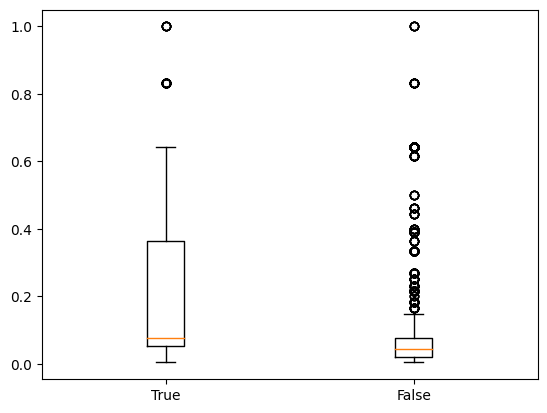

In [ ]:
# is_converted를 기준으로 True, False를 가진 데이터로 나눈 뒤 com_reg_ver_win_rate를 boxplot으로 시각화한다.
# 'is_converted'가 True인 데이터셋의 'com_reg_ver_win_rate' 선택
data_true = combined_data[combined_data['is_converted'] == True]['com_reg_ver_win_rate'].dropna()

# 'is_converted'가 False인 데이터셋의 'com_reg_ver_win_rate' 선택
data_false = combined_data[combined_data['is_converted'] == False]['com_reg_ver_win_rate'].dropna()

# 데이터가 있는지 확인
if len(data_true) > 0 and len(data_false) > 0:
    # Boxplot 그리기
    fig, ax = plt.subplots()
    ax.boxplot([data_true, data_false], labels=['True', 'False'])
    plt.show()
else:
    print("데이터가 충분하지 않습니다.")

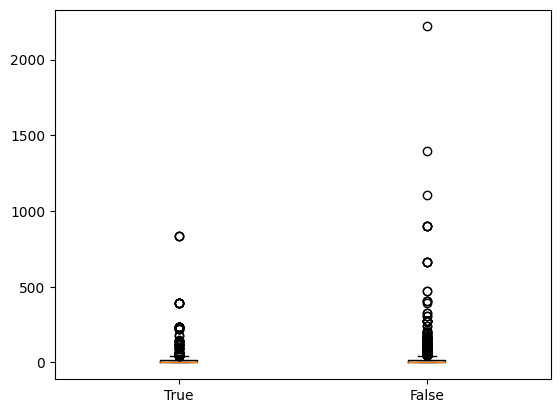

In [ ]:
data_true = combined_data[combined_data['is_converted'] == True]['historical_existing_cnt'].dropna()

# 'is_converted'가 False인 데이터셋의 'historical_existing_cnt' 선택
data_false = combined_data[combined_data['is_converted'] == False]['historical_existing_cnt'].dropna()

# 데이터가 있는지 확인
if len(data_true) > 0 and len(data_false) > 0:
    # Boxplot 그리기
    fig, ax = plt.subplots()
    ax.boxplot([data_true, data_false], labels=['True', 'False'])
    plt.show()
else:
    print("데이터가 충분하지 않습니다.")

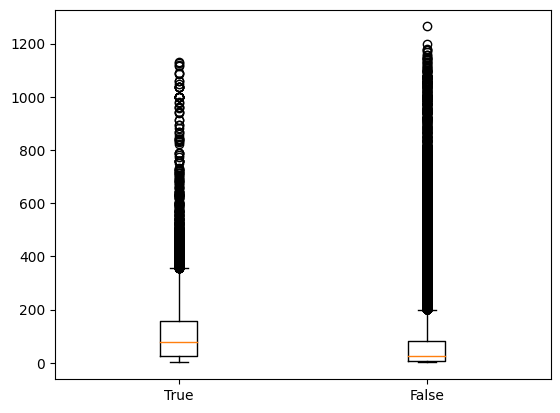

In [ ]:
data_true = combined_data[combined_data['is_converted'] == True]['lead_desc_length'].dropna()

# 'is_converted'가 False인 데이터셋의 'historical_existing_cnt' 선택
data_false = combined_data[combined_data['is_converted'] == False]['lead_desc_length'].dropna()

# 데이터가 있는지 확인
if len(data_true) > 0 and len(data_false) > 0:
    # Boxplot 그리기
    fig, ax = plt.subplots()
    ax.boxplot([data_true, data_false], labels=['True', 'False'])
    plt.show()
else:
    print("데이터가 충분하지 않습니다.")